Delays original data source: https://www1.toronto.ca/wps/portal/contentonly?vgnextoid=fa6be8c5a612c510VgnVCM10000071d60f89RCRD

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
delays = pd.read_csv('csv_originals/delays.csv', encoding = "ISO-8859-1")

In [3]:
delays.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,1/1/2014,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
1,1/1/2014,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
2,1/1/2014,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
3,1/1/2014,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386
4,1/1/2014,03:29,Wednesday,DUFFERIN STATION,MUPAA,0,0,E,BD,5174


In [4]:
delays.isnull().any()
## Looks like Code, Bound and Line coutain NaNs

Date         False
Time         False
Day          False
Station      False
Code          True
Min Delay    False
Min Gap      False
Bound         True
Line          True
Vehicle      False
dtype: bool

## Date

In [5]:
dates = pd.to_datetime(delays['Date'])

In [6]:
years = dates.dt.year
months = dates.dt.month
days = dates.dt.day
years.unique(), months.unique(), days.unique()

(array([2014, 2015, 2016, 2017]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))

The years are between the expected 2014-2017 and the months/days look reasonable so no clean up on *Date*

## Time

In [7]:
hours = pd.to_datetime(delays['Time'], format='%H:%M').dt.hour
minutes = pd.to_datetime(delays['Time'], format='%H:%M').dt.minute
hours.min(), hours.max(), minutes.min(), minutes.max()

(0, 23, 0, 59)

Looks like the hours are within 0 - 23 and the minutes are within 0-59 so no clean up needed for *Time*

## Day

In [8]:
delays['Day'].unique()

array(['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday'], dtype=object)

Days look reasonable so no clean up

Make sure the days from the day column match the day from the date?

In [9]:
dates_day = delays.copy()[['Day', 'Date']]
dates_day['Date'] = pd.to_datetime(dates_day['Date'])
dates_day['Date Day'] = dates_day['Date'].dt.weekday_name
dates_day[dates_day['Date Day'] != dates_day['Day']]

,Day,Date,Date Day


Looks like the *Day* column matches the expected date so no clean up here

## Station

In [15]:
delays['Station'].drop_duplicates().sort_values()

41188             (APPROACHING)
41018    0SSINGTON STATION (ENT
70435       169 DANFORTH AVENUE
39741    401 EMERGENCY EE (SHEP
42551     APPROACHING DOWNSVIEW
47634     APPROACHING HIGH PARK
2531     APPROACHING KEELE STAT
59133    APPROACHING KENNEDY BD
39046      APPROACHING LAWRENCE
66605    APPROACHING LAWRENCE S
37369    APPROACHING LESLIE STA
51425     APPROACHING OSSINGTON
26048    APPROACHING VICTORIA P
60229        APPROACHING WARDEN
44476    APPROACHING WARDEN STA
47937    APPROACHING WILSON STA
20309         APPROACHING YONGE
48403      APPROCHING DOWNSVIEW
59520        APROACHING MCCOWAN
27166        ASQUITH SUBSTATION
22806     BATHURST (APPROACHING
10064           BATHURST STAION
158            BATHURST STATION
17516    BATHURST STATION (APPR
15497    BATHURST STATION (ENTE
16813    BATHURST STATION (EXIT
17325    BATHURST STATION (IN T
18515    BATHURST STATION (LEAV
13325    BATHURST STATION (WEST
67072    BATHURST STATION - APP
                  ...          
58350   

In [17]:
# Source https://www1.toronto.ca/wps/portal/contentonly?vgnextoid=c077c316f16e8410VgnVCM10000071d60f89RCRD&vgnextchannel=7807e03bb8d1e310VgnVCM10000071d60f89RCRD
ttc_stations = pd.read_csv('stations.csv')
ttc_stations.head(2)

,Rank,Subway/RT Station,To Trains,From Trains,Totals,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,1,"Bloor (line 1, Y-U)","103,975","112,214","216,189",NaN,NaN,NaN,NaN,NaN,NaN
1,2,"Yonge (line 2, B-D)","95,407","87,831","183,238",NaN,NaN,NaN,NaN,NaN,NaN


The station in the above data all have their line in brackets but this will cause issues comparing to the delay data.

Strip the station name from the bracket, the delay data has the exact line so we can use this to differentiate the data

In [54]:
ttc_stations['Short Name'] = ttc_stations['Subway/RT Station'].dropna().str.split('(').str.get(0).str.upper().str.strip()

# Fix up SHEPPARD and MAIN to match the delay data better
ttc_stations[ttc_stations['Short Name'] == 'SHEPPARD-YONGE'] = 'SHEPPARD'
ttc_stations[ttc_stations['Short Name'] == 'MAIN STREET'] = 'MAIN'

# Drop any NaNs and grab just the uniques
ttc_stations_names = ttc_stations['Short Name'].dropna().unique()

'''
Some stations have a 'West' version and ideally we want these first since we don't want to
misclasify St. Clear West as St Clair so we reverse sort the names so the longer name is first
'''
ttc_stations_names = np.sort(ttc_stations_names)[::-1]

ttc_stations_names

array(['YORKDALE', 'YORK MILLS', 'YONGE', 'WOODBINE', 'WILSON',
       'WELLESLEY', 'WARDEN', 'VICTORIA PARK', 'UNION', 'SUMMERHILL',
       'ST. PATRICK', 'ST. GEORGE', 'ST. CLAIR WEST', 'ST. CLAIR',
       'ST. ANDREW', 'SPADINA', 'SHERBOURNE', 'SHEPPARD',
       'SCARBOROUGH CENTRE', 'RUNNYMEDE', 'ROYAL YORK', 'ROSEDALE',
       "QUEEN'S PARK", 'QUEEN', 'PAPE', 'OSSINGTON', 'OSGOODE', 'OLD MILL',
       'NORTH YORK CENTRE', 'MUSEUM', 'MIDLAND', 'MCCOWAN', 'MAIN',
       'LESLIE', 'LAWRENCE WEST', 'LAWRENCE EAST', 'LAWRENCE', 'LANSDOWNE',
       'KIPLING', 'KING', 'KENNEDY', 'KEELE', 'JANE', 'ISLINGTON',
       'HIGH PARK', 'GREENWOOD', 'GLENCAIRN', 'FINCH', 'ELLESMERE',
       'EGLINTON WEST', 'EGLINTON', 'DUPONT', 'DUNDAS WEST', 'DUNDAS',
       'DUFFERIN', 'DOWNSVIEW', 'DONLANDS', 'DON MILLS', 'DAVISVILLE',
       'COXWELL', 'COLLEGE', 'CHRISTIE', 'CHESTER', 'CASTLE FRANK',
       'BROADVIEW', 'BLOOR', 'BESSARION', 'BAYVIEW', 'BAY', 'BATHURST'], dtype=object)

Save the original stations and count how many there were

In [55]:
delays['Station_original'] = delays['Station']
stations = delays['Station']
# 76801 Way too many stations!
stations.count()

76801

Fixing up some inconsistencies with the delays stations. The St are need to be normalized and some common typos fixed

In [56]:
def fix_station(station):
    if station.startswith('ST'):
#         return station.replace('ST.', 'ST. ').replace('ST ', 'ST. ')
        return station.replace('ST.', 'ST. ').replace('ST ', 'ST. ').replace('ST.  ', 'ST. ')
    elif station == 'NORTH YORK CTR STATION' or station == 'NORTH YORK CENTER' or station == 'NORTH YORK CENTER STAT':
        return 'NORTH YORK CENTRE'
    elif '0SSINGTON' in station:
        return station.replace('0SSINGTON', 'OSSINGTON')
    elif 'BESSARIAN' in station or 'BESSARRION' in station:
        return 'BESSARION'
    elif 'BUTHURST' in station:
        return 'BATHURST'
    elif 'SCARB' in station or 'SCARBOROUGH' in station or 'SCAB' in station or 'SCAR' in station and 'RAPID' not in station:
        return 'SCARBOROUGH CENTRE'
    elif 'DOWNVIEW' in station:
        return 'DOWNSVIEW'
    else: 
        return station
    
# Store the newly fixed stations in it's own column  
delays['Station_Fixed'] = delays['Station_original'].apply(fix_station)
delays

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Station_original,Station_Fixed
0,1/1/2014,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,HIGH PARK STATION,HIGH PARK STATION
1,1/1/2014,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0,SHEPPARD STATION,SHEPPARD STATION
2,1/1/2014,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,LANSDOWNE STATION,LANSDOWNE STATION
3,1/1/2014,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,BLOOR STATION,BLOOR STATION
4,1/1/2014,03:29,Wednesday,DUFFERIN STATION,MUPAA,0,0,E,BD,5174,DUFFERIN STATION,DUFFERIN STATION
5,1/1/2014,07:31,Wednesday,NORTH YORK CENTRE STAT,MUNCA,0,0,NaN,YU,0,NORTH YORK CENTRE STAT,NORTH YORK CENTRE STAT
6,1/1/2014,07:32,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0,SHEPPARD STATION,SHEPPARD STATION
7,1/1/2014,07:34,Wednesday,RUNNYMEDE STATION,MUNCA,0,0,NaN,BD,0,RUNNYMEDE STATION,RUNNYMEDE STATION
8,1/1/2014,07:34,Wednesday,QUEEN STATION EAST SID,MUNCA,0,0,NaN,YU,0,QUEEN STATION EAST SID,QUEEN STATION EAST SID
9,1/1/2014,07:53,Wednesday,ST ANDREW STATION,MUNCA,0,0,NaN,YU,0,ST ANDREW STATION,ST. ANDREW STATION


Now that we have a list of known stations and a cleaner list of stations lets take our best guess at the 'Normalized Station'

**Warning** sometimes the above code is slow or gets stuck you can kill the kernal and restart

In [57]:
def estimate_station(original_station):
    for station_name in ttc_stations_names:        
        if station_name in original_station:
            return station_name
        
    return np.NaN
delays['Station'] = delays['Station_Fixed'].apply(estimate_station)
delays.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Station_original,Station_Fixed
0,1/1/2014,02:06,Wednesday,HIGH PARK,SUDP,3,7,W,BD,5001,HIGH PARK STATION,HIGH PARK STATION
1,1/1/2014,02:40,Wednesday,SHEPPARD,MUNCA,0,0,NaN,YU,0,SHEPPARD STATION,SHEPPARD STATION
2,1/1/2014,03:10,Wednesday,LANSDOWNE,SUDP,3,8,W,BD,5116,LANSDOWNE STATION,LANSDOWNE STATION
3,1/1/2014,03:20,Wednesday,BLOOR,MUSAN,5,10,S,YU,5386,BLOOR STATION,BLOOR STATION
4,1/1/2014,03:29,Wednesday,DUFFERIN,MUPAA,0,0,E,BD,5174,DUFFERIN STATION,DUFFERIN STATION


Next lets check out the stations that are still unknown -- also add a check here removing all the stations where the Line is null since those data points likely have issues with the stations

In [58]:
# delays
unknown_station = delays[delays['Station'].isnull() & (delays['Line'].notnull())]
len(unknown_station['Station_Fixed'].unique())
# unknown_station['Station'].unique()
print(len(unknown_station))
unknown_station.groupby('Station_Fixed').size().sort_values(ascending=False)

342


Station_Fixed
TORONTO TRANSIT COMMIS    186
SRT LINE                   20
DANFORTH DIVISION          10
TRANSIT CONTROL CENTRE      6
MCBRIEN BUILDING            4
CANADIAN ARMED FORCES       3
VARIOUS                     3
CHANGE OVERS / GENERAL      3
SYSTEM WIDE                 2
GENERAL DELAY / CHANGE      2
TRANSIT CONTROL             2
YUS                         2
YOUNGE/UNIVERSITY - LI      2
GREEWOOD STATION            2
APPROACHING VICTORIA P      2
YOUNG UNIVERSITY SUBWA      2
FENMAR AND WESTON           1
DUPLEX AVENUE               1
DOWNSIVEW STATION (APP      1
DOWSVIEW STATION            1
EGLINGTON STATION           1
EXITING ST CLAIR WEST       1
YUS/BD/SRT                  1
FULL LINE                   1
GLENACAIRN STATION          1
DOWNSIVEW STATION           1
GLENCARIAN (APPROACHIN      1
GLENCARIAN STATION          1
GREEENWOOD WYE (YARD A      1
GREEN                       1
                         ... 
YOUNGE/UNIVERSITY-BLOO      1
YOUNGE/UNIVERSITY/SAPD    

It looks like we weren't able to classify 342 of the original stations but from a quick glance some of of these aren't real station (like TRANISIT CONTORL, DANFORTH DIVISION )

Interestingly some of there seem like entire lines or Systems (SYSTEM WIDE, SRT LINE ) which may be worth looking at individually than the stations

In [59]:
# Quick glance at the final stations
delays.groupby('Station').size()

Station
BATHURST               684
BAY                    542
BAYVIEW                316
BESSARION              187
BLOOR                 3513
BROADVIEW              774
CASTLE FRANK           443
CHESTER                628
CHRISTIE               888
COLLEGE                698
COXWELL               1228
DAVISVILLE            1347
DON MILLS              726
DONLANDS               752
DOWNSVIEW             1970
DUFFERIN               497
DUNDAS                 807
DUNDAS WEST            915
DUPONT                 757
EGLINTON              1853
EGLINTON WEST         1013
ELLESMERE              193
FINCH                 2418
GLENCAIRN              608
GREENWOOD             1356
HIGH PARK              475
ISLINGTON             1808
JANE                  1482
KEELE                 2139
KENNEDY               4105
                      ... 
MUSEUM                 483
NORTH YORK CENTRE      566
OLD MILL               912
OSGOODE                401
OSSINGTON              822
PAPE                

## Line

In [22]:
delays['Line'].drop_duplicates()

0                         BD
1                         YU
42                       SHP
69                       NaN
112                      SRT
1638                 BD LINE
2769     BLOOR DANFORTH LINE
6934                  BD/YUS
8508          BLOOR DANFORTH
13242           31 GREENWOOD
16460                     60
19043              9 BELLAMY
19787             45 KIPLING
22464                    504
24649          95 YORK MILLS
26063                    500
27916               SHEPPARD
30627            104 FAYWOOD
31202                  YU/BD
31878        60 STEELES WEST
32365           25 DON MILLS
35841                    555
38380          36 FINCH WEST
40920           126 CHRISTIE
41157           37 ISLINGTON
43092               504 KING
43222            29 DUFFERIN
43554        116 MORNINGSIDE
44302                  BD/YU
47787          73 ROYAL YORK
55698                YU/SHEP
57163                     66
60317              341 KEELE
62569            510 SPADINA
65485         

In [60]:
# Similar to station store the original lines
delays['Line_ori'] = delays['Line']

Based on the metadata that came with the data we know there are only 4 real lines so we can map these with their full name which will also convert the rest to null

In [61]:
expected_lines = {'BD': 'Bloor-Danforth', 'YU': 'Yonge-University', 'SHP' : 'Sheppard', 'SRT' : 'Scarborough RT'}
delays['Line'] = delays['Line_ori'].map(expected_lines)

## Intersection Stations

We need to rename the stations that are at the intersections (Bloor/Yonge/Sheppard)

In [62]:
exchange_stations = delays[delays['Station'].isin(['BLOOR', 'SHEPPARD', 'YONGE', 'ST. GEORGE', 'KENNEDY', 'SPADINA'])]
exchange_stations.groupby(['Station', 'Line']).size()

Station     Line            
BLOOR       Bloor-Danforth      1835
            Yonge-University    1634
KENNEDY     Bloor-Danforth      3402
            Scarborough RT       684
            Yonge-University       3
SHEPPARD    Bloor-Danforth        37
            Sheppard              50
            Yonge-University    1094
SPADINA     Bloor-Danforth       609
            Yonge-University     555
ST. GEORGE  Bloor-Danforth      1408
            Yonge-University    1274
YONGE       Bloor-Danforth      1703
            Sheppard            1031
            Yonge-University    2802
dtype: int64

In [63]:
def fix_station(station, line, new_name):
    delays.loc[(delays['Station'] == station) & (delays['Line'] == line), 'Station'] = new_name

In [64]:
fix_station('BLOOR', 'Bloor-Danforth', 'BLOOR-YONGE - BD')
fix_station('BLOOR', 'Yonge-University', 'BLOOR-YONGE - YU')
fix_station('YONGE', 'Bloor-Danforth', 'BLOOR-YONGE - BD')
fix_station('YONGE', 'Yonge-University', 'BLOOR-YONGE - YU')

fix_station('SHEPPARD', 'Yonge-University', 'SHEPPARD - YU')
fix_station('SHEPPARD', 'Sheppard', 'SHEPPARD - SHP')
fix_station('YONGE', 'Sheppard', 'SHEPPARD - SHP')

fix_station('SPADINA', 'Yonge-University', 'SPADINA - YU')
fix_station('SPADINA', 'Bloor-Danforth', 'SPADINA - BD')

fix_station('ST. GEORGE', 'Yonge-University', 'ST. GEORGE - YU')
fix_station('ST. GEORGE', 'Bloor-Danforth', 'ST. GEORGE - BD')

fix_station('KENNEDY', 'Scarborough RT', 'KENNEDY - SRT')
fix_station('KENNEDY', 'Bloor-Danforth', 'KENNEDY - BD')

In [65]:
exchange_stations = delays[delays['Station'].isin(['BLOOR', 'SHEPPARD', 'YONGE', 'ST. GEORGE', 'KENNEDY', 'SPADINA'])]
exchange_stations.groupby(['Station', 'Line']).size()

Station   Line            
KENNEDY   Yonge-University     3
SHEPPARD  Bloor-Danforth      37
dtype: int64

## Bound

The meta data says that Bound should be a direction N/S/E/W so we can likely drop the B/R/Y which may have been typos

In [66]:
delays.groupby('Bound').size()

Bound
B       35
E    15281
N    12882
R        1
S    15271
W    16876
Y        2
dtype: int64

In [67]:
expected_directions = {'E': 'East', 'N': 'North', 'W':'West', 'S':'South'}
delays['Bound'] = delays['Bound'].map(expected_directions)
delays.groupby('Bound').size()

Bound
East     15281
North    12882
South    15271
West     16876
dtype: int64

We also know something about the lines -- Yonge/University line only goes North/South, Bloor Danforth/Sheppard/Scarboughout RT only does East/West so we can NaN any values that don't match that

In [68]:
delays_with_line = delays[delays['Line'].notnull()]
num_non_null_bound = len(delays_with_line[delays_with_line['Bound'].notnull()])
num_null_bound = len(delays_with_line[delays_with_line['Bound'].isnull()])
total_delay = len(delays_with_line)

print('Number of delays with non-null Bound: ', num_non_null_bound)
print('Number of delays with null Bound', num_null_bound)
print('Percentage of null ', (num_null_bound/total_delay))

Number of delays with non-null Bound:  60266
Number of delays with null Bound 15779
Percentage of null  0.20749556183838516


In [69]:
# Fix up the YU line
non_null_yu = delays[(delays['Line'] == 'Yonge-University') & (delays['Bound'].notnull())]

invalid_yu_mask = ~non_null_yu['Bound'].isin(['North','South'])
invalid_yu = non_null_yu[invalid_yu_mask]
num_invalid_yu = len(invalid_yu)
print('Number of Invalid Bounds on the Yonge/Univerity line ', num_invalid_yu)
print('Number of entries on the Yonge/Univerity line ', len(non_null_yu))
print('Percent of Younge Line Bound being removed: ', num_invalid_yu/len(non_null_yu) * 100)

Number of Invalid Bounds on the Yonge/Univerity line  60
Number of entries on the Yonge/Univerity line  25977
Percent of Younge Line Bound being removed:  0.23097355352812102


Looks like 0.23% of the Yonge University Line Bounds were classified with the wrong Bond direction

In [70]:
# Convert all the East/West to NaN
yu_mask = (delays['Line'] == 'Yonge-University') & (delays['Bound'].notnull()) &(~delays['Bound'].isin(['North','South']))
delays.loc[yu_mask, 'Bound'] = np.NaN
delays[yu_mask]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Station_original,Station_Fixed,Line_ori
1499,1/27/2014,11:37,Monday,BLOOR-YONGE - YU,MUTD,4,10,NaN,Yonge-University,5286,YONGE SHP STATION (APP,YONGE SHP STATION (APP,YU
2076,2/5/2014,10:44,Wednesday,BESSARION,TUSC,0,0,NaN,Yonge-University,5238,BESSARION STATION APPR,BESSARION STATION APPR,YU
2077,2/5/2014,14:06,Wednesday,BLOOR-YONGE - YU,PUSTS,4,10,NaN,Yonge-University,5243,YONGE SHP STATION (APP,YONGE SHP STATION (APP,YU
2658,2/13/2014,18:00,Thursday,BLOOR-YONGE - YU,MUPAA,0,0,NaN,Yonge-University,5251,YONGE SHP STATION,YONGE SHP STATION,YU
13215,8/23/2014,07:53,Saturday,HIGH PARK,TUSC,0,0,NaN,Yonge-University,5307,HIGH PARK STATION,HIGH PARK STATION,YU
13221,8/23/2014,10:35,Saturday,ROYAL YORK,TUSC,0,0,NaN,Yonge-University,5207,ROYAL YORK STATION,ROYAL YORK STATION,YU
13226,8/23/2014,13:27,Saturday,ROYAL YORK,MUI,5,9,NaN,Yonge-University,5254,ROYAL YORK STATION,ROYAL YORK STATION,YU
14110,9/7/2014,19:56,Sunday,WELLESLEY,SUAE,0,0,NaN,Yonge-University,0,WELLESLEY STATION,WELLESLEY STATION,YU
16524,10/22/2014,05:33,Wednesday,BLOOR-YONGE - YU,TUSC,0,0,NaN,Yonge-University,5200,BLOOR STATION,BLOOR STATION,YU
20414,12/31/2014,23:15,Wednesday,WARDEN,MUPAA,0,0,NaN,Yonge-University,5367,WARDEN STATION,WARDEN STATION,YU


In [71]:
non_null_other = delays[(delays['Line'] != 'Yonge-University') & (delays['Line'].notnull()) & (delays['Bound'].notnull())]

invalid_other = non_null_other[~non_null_other['Bound'].isin(['East','West'])]
num_invalid_other = len(invalid_other)
print('Number of Invalid Bounds on the Other Line line ', num_invalid_other)
print('Number of entries on the Other Lines ', len(non_null_other))
print('Percent of Other Line Bound being removed: ', num_invalid_other/len(non_null_other) * 100)

Number of Invalid Bounds on the Other Line line  2214
Number of entries on the Other Lines  34289
Percent of Other Line Bound being removed:  6.456881215550177


In [72]:
# Convert all the North/South to NaN
other_mask = (delays['Line'] != 'Yonge-University') & (delays['Line'].notnull()) & (delays['Bound'].notnull()) &(~delays['Bound'].isin(['East','West']))
delays.loc[other_mask, 'Bound'] = np.NaN
delays[other_mask]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Station_original,Station_Fixed,Line_ori
112,1/2/2014,07:25,Thursday,LAWRENCE EAST,ERDO,0,0,NaN,Scarborough RT,3007,LAWRENCE EAST STATION,LAWRENCE EAST STATION,SRT
113,1/2/2014,07:40,Thursday,KENNEDY - SRT,ERDO,4,9,NaN,Scarborough RT,3021,KENNEDY SRT STATION,KENNEDY SRT STATION,SRT
114,1/2/2014,07:53,Thursday,MCCOWAN,ERDO,0,0,NaN,Scarborough RT,3004,MCCOWAN STATION,MCCOWAN STATION,SRT
115,1/2/2014,09:29,Thursday,MIDLAND,ERDO,0,0,NaN,Scarborough RT,3027,MIDLAND STATION,MIDLAND STATION,SRT
116,1/2/2014,12:38,Thursday,ELLESMERE,ERTC,9,15,NaN,Scarborough RT,3016,ELLESMERE STATION,ELLESMERE STATION,SRT
117,1/2/2014,15:35,Thursday,LAWRENCE EAST,ERTC,7,11,NaN,Scarborough RT,3017,LAWRENCE EAST STATION,LAWRENCE EAST STATION,SRT
118,1/2/2014,15:49,Thursday,MIDLAND,ERTC,5,9,NaN,Scarborough RT,3017,MIDLAND STATION,MIDLAND STATION,SRT
119,1/2/2014,21:21,Thursday,MCCOWAN,ERWA,6,12,NaN,Scarborough RT,3027,MCCOWAN STATION,MCCOWAN STATION,SRT
120,1/2/2014,00:12,Thursday,MCCOWAN,ERWA,6,12,NaN,Scarborough RT,3027,MCCOWAN STATION,MCCOWAN STATION,SRT
175,1/3/2014,06:09,Friday,MCCOWAN,ERTC,3,9,NaN,Scarborough RT,3002,MCCOWAN STATION,MCCOWAN STATION,SRT


Looks like we will end up removing 6% of the other lines

## Vehicle

Empty vehicle numbers seem to be treated as 0 but NaN or None is likely more appropriate here

In [73]:
delays['Vehicle'] = delays['Vehicle'].replace(0, np.NaN)

In [48]:
vehicle_grouping = delays.groupby('Vehicle').size()
# vehicle_grouping

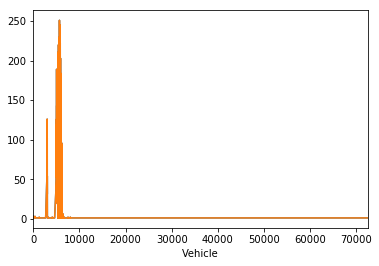

In [53]:
# vehicle_grouping.hist()
vehicle_grouping.plot()
plt.show()

## Codes

We recieved the full code names from the data set so we can put the description in the table

In [74]:
codes = pd.read_csv('codes.csv')
# Likely due to an encoding issue but the Code column is 'SUB RMENU CODE' so rename it to Code
codes['Code'] = codes['SUB RMENU CODE']
codes['Code Description'] = codes['CODE DESCRIPTION']

To get the codes into our delays dataframe we need to merge the codes

In [75]:
delays = delays.merge(codes, how='left', on='Code')
delays

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Station_original,Station_Fixed,Line_ori,SUB RMENU CODE,CODE DESCRIPTION,Code Description
0,1/1/2014,02:06,Wednesday,HIGH PARK,SUDP,3,7,West,Bloor-Danforth,5001.0,HIGH PARK STATION,HIGH PARK STATION,BD,SUDP,Disorderly Patron,Disorderly Patron
1,1/1/2014,02:40,Wednesday,SHEPPARD - YU,MUNCA,0,0,NaN,Yonge-University,NaN,SHEPPARD STATION,SHEPPARD STATION,YU,NaN,NaN,NaN
2,1/1/2014,03:10,Wednesday,LANSDOWNE,SUDP,3,8,West,Bloor-Danforth,5116.0,LANSDOWNE STATION,LANSDOWNE STATION,BD,SUDP,Disorderly Patron,Disorderly Patron
3,1/1/2014,03:20,Wednesday,BLOOR-YONGE - YU,MUSAN,5,10,South,Yonge-University,5386.0,BLOOR STATION,BLOOR STATION,YU,MUSAN,Unsanitary Vehicle,Unsanitary Vehicle
4,1/1/2014,03:29,Wednesday,DUFFERIN,MUPAA,0,0,East,Bloor-Danforth,5174.0,DUFFERIN STATION,DUFFERIN STATION,BD,MUPAA,Passenger Assistance Alarm Activated - No Trou...,Passenger Assistance Alarm Activated - No Trou...
5,1/1/2014,07:31,Wednesday,NORTH YORK CENTRE,MUNCA,0,0,NaN,Yonge-University,NaN,NORTH YORK CENTRE STAT,NORTH YORK CENTRE STAT,YU,NaN,NaN,NaN
6,1/1/2014,07:32,Wednesday,SHEPPARD - YU,MUNCA,0,0,NaN,Yonge-University,NaN,SHEPPARD STATION,SHEPPARD STATION,YU,NaN,NaN,NaN
7,1/1/2014,07:34,Wednesday,RUNNYMEDE,MUNCA,0,0,NaN,Bloor-Danforth,NaN,RUNNYMEDE STATION,RUNNYMEDE STATION,BD,NaN,NaN,NaN
8,1/1/2014,07:34,Wednesday,QUEEN,MUNCA,0,0,NaN,Yonge-University,NaN,QUEEN STATION EAST SID,QUEEN STATION EAST SID,YU,NaN,NaN,NaN
9,1/1/2014,07:53,Wednesday,ST. ANDREW,MUNCA,0,0,NaN,Yonge-University,NaN,ST ANDREW STATION,ST. ANDREW STATION,YU,NaN,NaN,NaN


Let see if code codes didn't get translated 

In [76]:
# lets see if any codes don't have description
no_description = delays[delays['Code Description'].isnull()]
print('Number of non decoded values: ', len(no_description))

# Reverse sort by the number of entries of each of this code
no_description.groupby('Code').size().sort_values(ascending=False)

Number of non decoded values:  1778


Code
MUNCA     1561
PUTDN       97
TRNCA       48
XXXXX       27
TUNCA       17
MFO          5
SFDP         4
XXXXXX       3
MTUI         3
MUCSA        2
SFO          2
ETCA         1
MTO          1
PUTN         1
PUSIC        1
SFAE         1
SFAP         1
TUTD         1
ERTO         1
dtype: int64

Looks like most of these are one off's with the exception of *MUNCA* which has 1561 values!
One guess is this was meant to be MUNOA,No Operator Immediately Available - Not E.S.A. Related  or it could be missing from the code list

In [77]:
# List out the codes with the most common one first
delays.groupby('Code Description').size().sort_values(ascending=False).head(20)

Code Description
Miscellaneous Speed Control                                   13741
Operator Overspeeding                                         10192
Passenger Assistance Alarm Activated - No Trouble Found        4943
Miscellaneous General Delays                                   4094
Injured or ill Customer (In Station) - Transported             4021
Miscellaneous Other                                            3535
Disorderly Patron                                              2681
Injured or ill Customer (On Train) - Medical Aid Refused       2409
Injured or ill Customer (On Train) - Transported               2093
Operator Violated Signal                                       1766
Escalator/Elevator Incident                                    1721
Door Problems - Faulty Equipment                               1448
Passenger Other                                                1125
Brakes                                                         1095
Misc. Transportation Other - Em

In [78]:
# Not really clean up I just was curcious how many of these were 'Passenger' related
filled = delays['Code Description'].fillna('')
pass_related = filled[filled.str.contains('Passenger')].unique()

In [79]:
pass_delays = delays[delays['Code Description'].isin(pass_related)]
print(len(pass_delays))
pass_delays.groupby('Code Description').size()

6414


Code Description
Door Problems - Passenger Related                           346
Passenger Assistance Alarm Activated - No Trouble Found    4943
Passenger Other                                            1125
dtype: int64

In [80]:
# Remove some not really useful columns before exporting (CODE DESCRIPTION is a duplicate)
delays = delays.drop(['Station_Fixed', 'SUB RMENU CODE', 'CODE DESCRIPTION'], axis=1)

In [81]:
delays.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Station_original,Line_ori,Code Description
0,1/1/2014,02:06,Wednesday,HIGH PARK,SUDP,3,7,West,Bloor-Danforth,5001.0,HIGH PARK STATION,BD,Disorderly Patron
1,1/1/2014,02:40,Wednesday,SHEPPARD - YU,MUNCA,0,0,NaN,Yonge-University,NaN,SHEPPARD STATION,YU,NaN
2,1/1/2014,03:10,Wednesday,LANSDOWNE,SUDP,3,8,West,Bloor-Danforth,5116.0,LANSDOWNE STATION,BD,Disorderly Patron
3,1/1/2014,03:20,Wednesday,BLOOR-YONGE - YU,MUSAN,5,10,South,Yonge-University,5386.0,BLOOR STATION,YU,Unsanitary Vehicle
4,1/1/2014,03:29,Wednesday,DUFFERIN,MUPAA,0,0,East,Bloor-Danforth,5174.0,DUFFERIN STATION,BD,Passenger Assistance Alarm Activated - No Trou...


In [82]:
delays.to_csv('ttc_delays_cleaned.csv', index=False)

In [83]:
delays['Min Gap'].describe()

count    76801.000000
mean         2.700993
std          8.629974
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max        999.000000
Name: Min Gap, dtype: float64

In [84]:
delays['Min Delay'].describe()

count    76801.000000
mean         1.833049
std          8.671275
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        999.000000
Name: Min Delay, dtype: float64

In [85]:
cleaned = pd.read_csv('ttc_delays_cleaned.csv')

In [86]:
cleaned.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Station_original,Line_ori,Code Description
0,1/1/2014,02:06,Wednesday,HIGH PARK,SUDP,3,7,West,Bloor-Danforth,5001.0,HIGH PARK STATION,BD,Disorderly Patron
1,1/1/2014,02:40,Wednesday,SHEPPARD - YU,MUNCA,0,0,NaN,Yonge-University,NaN,SHEPPARD STATION,YU,NaN
2,1/1/2014,03:10,Wednesday,LANSDOWNE,SUDP,3,8,West,Bloor-Danforth,5116.0,LANSDOWNE STATION,BD,Disorderly Patron
3,1/1/2014,03:20,Wednesday,BLOOR-YONGE - YU,MUSAN,5,10,South,Yonge-University,5386.0,BLOOR STATION,YU,Unsanitary Vehicle
4,1/1/2014,03:29,Wednesday,DUFFERIN,MUPAA,0,0,East,Bloor-Danforth,5174.0,DUFFERIN STATION,BD,Passenger Assistance Alarm Activated - No Trou...
